<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/10-introduction-to-artificial-neural-networks-with-keras/building_image_classifier_using_sequential_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building an Image Classifier Using the Sequential API

## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

TensorFlow 2.x selected.
2.0.0


In [0]:
from tensorflow import keras

## Load the dataset

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in keras.datasets. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


The training set contains 60,000 grayscale images, each 28x28 pixels:

In [5]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [6]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [0]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

With MNIST, when the label is equal to 5, it means that the image represents the handwritten digit 5. Easy. 

For Fashion MNIST, however, we need the list of class names to know what we are dealing with:

In [0]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [9]:
class_names[y_train[0]]

'Coat'

You can plot an image using Matplotlib's imshow() function, with a 'binary' color map:

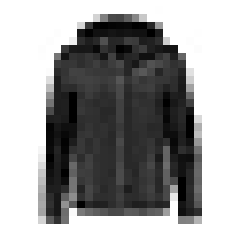

In [10]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [11]:
X_valid.shape

(5000, 28, 28)

In [12]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

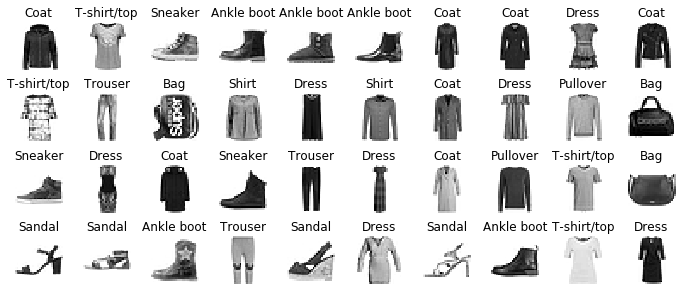

In [13]:
n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
  for col in range(n_cols):
    index = n_cols * row + col 
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
    plt.axis('off')
    plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()    

## Creating the model using the Sequential API

Now let’s build the neural network! Here is a classification MLP with two hidden layers:

In [0]:
model = keras.models.Sequential()
''' 
It is a Flatten layer whose role is to convert each input image into a 1D array: if it receives input data X, it computes X.reshape(-1, 1). 
This layer does not have any parameters; it is just there to do some simple preprocessing. 
Since it is the first layer in the model, you should specify the input_shape, which doesn’t include the batch size, only the shape of the instances.
Alternatively, you could add a keras.layers.InputLayer as the first layer, setting input_shape=[28,28].
'''
model.add(keras.layers.Flatten(input_shape=[28, 28]))  
# Dense hidden layer with 300 neurons. It will use the ReLU activation function.
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
# Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function
model.add(keras.layers.Dense(10, activation='softmax'))

In [0]:
# clear session and reset seed
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Instead of adding the layers one by one as we just did, you can pass a list of layers when creating the Sequential model:

In [0]:
model = keras.models.Sequential([
     keras.layers.Flatten(input_shape=[28, 28]),
     keras.layers.Dense(300, activation='relu'),
     keras.layers.Dense(100, activation='relu'),
     keras.layers.Dense(10, activation='softmax')                            
])

The model’s summary() method displays all the model’s layers, including each layer’s name, its output shape  and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


We can also plot the model structure.

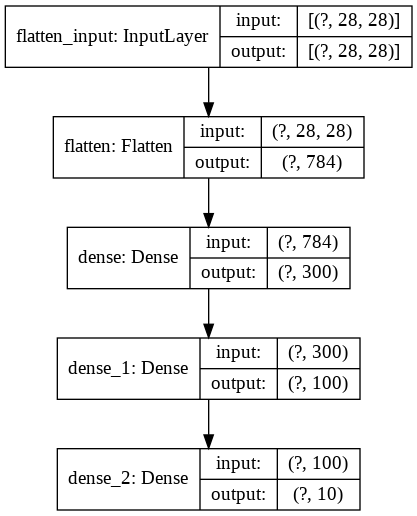

In [26]:
keras.utils.plot_model(model, 'my_mnist_model.png', show_shapes=True)

Note that Dense layers often have a lot of parameters. For example, the first hidden layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters! This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data.

You can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch it by name:

In [19]:
model.layers

In [20]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [21]:
model.get_layer('dense') is hidden1

True

All the parameters of a layer can be accessed using its get_weights() and set_weights() methods. 

In [22]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [23]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [24]:
weights.shape

(784, 300)

In [25]:
biases.shape

(300,)

Notice that the Dense layer initialized the connection weights randomly (which is needed to break symmetry), and the biases were initialized to zeros, which is fine. If you ever want to use a different initialization method, you can set kernel_initializer (kernel is another name for the matrix of connection weights) or bias_initializer when creating the layer.

**Note**

---

The shape of the weight matrix depends on the number of inputs. This is why it is recommended to specify the input_shape when creating the first layer in a Sequential model. 

However, if you do not specify the input shape, it’s OK: Keras will simply wait until it knows the input shape before it actually builds the model. This will happen either when you feed it actual data (e.g., during training), or when you call its build() method. Until the model is really built, the layers will not have any weights, and you will not be able to do certain things (such as print the model summary or save the model).

---


## Compiling the model

After a model is created, you must call its compile() method to specify the loss function and the optimizer to use. 

Optionally, you can specify a list of extra metrics to compute during training and evaluation:

In [0]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

We use the "sparse_categorical_crossentropy" loss because we have sparse labels (i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. 

If instead we had one target probability per class for each instance (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the "categorical_crossentropy" loss instead. 

If we were doing binary classification (with one or more binary labels), then we would use the "sigmoid" (i.e., logistic) activation function in the output layer instead of the "softmax" activation function, and we would use the "binary_crossentropy" loss.

Regarding the optimizer, "sgd" means that we will train the model using simple Stochastic Gradient Descent. In other words, Keras will perform the backpropagation algorithm (i.e., reverse-mode autodiff plus Gradient Descent).

Finally, since this is a classifier, it’s useful to measure its "accuracy" during training and evaluation.

## Training and evaluating the model

Now the model is ready to be trained. For this we simply need to call its fit() method:

In [29]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 8s 143us/sample - loss: 0.7228 - accuracy: 0.7623 - val_loss: 0.5304 - val_accuracy: 0.8162
Epoch 2/30
55000/55000 [==============================] - 6s 118us/sample - loss: 0.4837 - accuracy: 0.8322 - val_loss: 0.4497 - val_accuracy: 0.8454
Epoch 3/30
55000/55000 [==============================] - 7s 119us/sample - loss: 0.4380 - accuracy: 0.8473 - val_loss: 0.4174 - val_accuracy: 0.8558
Epoch 4/30
55000/55000 [==============================] - 6s 118us/sample - loss: 0.4128 - accuracy: 0.8554 - val_loss: 0.3899 - val_accuracy: 0.8656
Epoch 5/30
55000/55000 [==============================] - 6s 118us/sample - loss: 0.3929 - accuracy: 0.8624 - val_loss: 0.3966 - val_accuracy: 0.8610
Epoch 6/30
55000/55000 [==============================] - 7s 119us/sample - loss: 0.3775 - accuracy: 0.8668 - val_loss: 0.3726 - val_accuracy: 0.8740
Epoch 7/30
55000/55000 [===========================

The fit() method returns a History object containing
* the training parameters (history.params), 
* the list of epochs it went through (history.epoch), 
* and most importantly a dictionary (history.history) containing the loss and extra metrics it measured at the end of each epoch on the training set and on the validation set (if any).

In [30]:
history.params

{'batch_size': 32,
 'do_validation': True,
 'epochs': 30,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy'],
 'samples': 55000,
 'steps': 1719,
 'verbose': 0}

In [32]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

If you use this dictionary to create a pandas DataFrame and call its plot() method, you get the learning curves.

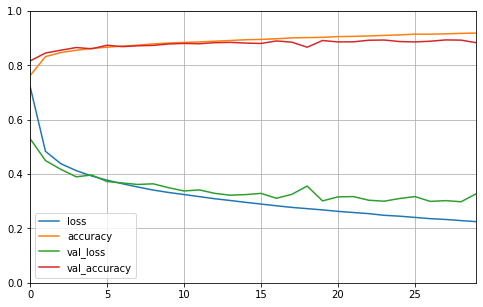

In [34]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

You can see that both the training accuracy and the validation accuracy steadily increase during training, while the training loss and the validation loss decrease. Good! Moreover, the validation curves are close to the training curves, which means that there is not too much overfitting.

the validation error is computed at the end of each epoch, while the training error is computed using a running mean during each epoch. So the training curve should be shifted by half an epoch to the left.

If you are not satisfied with the performance of your model, you should go back and tune the hyperparameters. 
* The first one to check is the learning rate. 
* If that doesn’t help, try another optimizer (and always retune the learning rate after changing any hyperparameter). 
* If the performance is still not great, then try tuning model hyperparameters such as the number of layers, the number of neurons per layer, and the types of activation functions to use for each hidden layer.
* You can also try tuning other hyperparameters, such as the batch size (it can be set in the fit() method using the batch_size argument, which defaults to 32).

Once you are satisfied with your model’s validation accuracy, you should evaluate it on the test set to estimate the generalization error before you deploy the model to production. You can easily do this using the evaluate() method.

In [35]:
model.evaluate(X_test, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3632489522576332, 0.8682]

## Using the model to make predictions

we can use the model’s predict() method to make predictions on new instances. Since we don’t have actual new instances, we will just use the first three instances of the test set:

In [36]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

As you can see, for each instance the model estimates one probability per class, from class 0 to class 9.

For example, for the first image it estimates that the probability of class 9 (ankle boot) is 96%, the probability of class 5 (sandal) is 3%, the probability of class 7 (sneaker) is 1%, and the probabilities of the other classes are negligible. In other words, it “believes” the first image is footwear, most likely ankle boots but possibly sandals or sneakers.

If you only care about the class with the highest estimated probability (even if that probability is quite low), then you can use the predict_classes() method instead:

In [37]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [38]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

Here, the classifier actually classified all three images correctly.

In [39]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

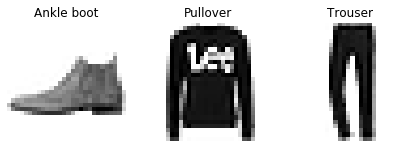

In [40]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
  plt.subplot(1, 3, index + 1)
  plt.imshow(image, cmap='binary', interpolation='nearest')
  plt.axis('off')
  plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()  